In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import skimage
from config import Config
import utils
import model as modellib
import visualize
from model import log

from sklearn.model_selection import train_test_split

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
    
seed=16

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [2]:
class NucleiConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "Nuclei_dat"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 1024

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 200

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 250

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 65
    
    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 100
    
config = NucleiConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  256
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           Nuclei_dat
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [4]:
class nuclei_dataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """
    gob_path=None
    def load_im(self, list_id, glob_path ):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        self.glob_path=glob_path
        # Add classes
        self.add_class("stage1_train", 1, "nuclei")

        # Add images
        k=0
        for Id in list_id:
            self.add_image("stage1_train", image_id=k, 
                           path=os.path.join(self.glob_path,Id,"images",Id+".png"),
                          id_str=Id)
            k+=1

    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        image = skimage.io.imread(self.image_info[image_id]['path'])[:,:,:3]
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        return image

#     def image_reference(self, image_id):
#         """Return the shapes data of the image."""
#         info = self.image_info[image_id]
#         if info["source"] == "shapes":
#             return info["shapes"]
#         else:
#             super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Load instance masks for the given image.
        Different datasets use different ways to store masks. Override this
        method to load instance masks and return them in the form of am
        array of binary masks of shape [height, width, instances].
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                a binary mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        # Override this function to load a mask from your dataset.
        # Otherwise, it returns an empty mask.
        path_masks=os.path.join(self.glob_path,self.image_info[image_id]["id_str"],"masks")
        mask=[]
        for id_mask in os.listdir(path_masks):
            mask+=[skimage.io.imread(os.path.join(path_masks,id_mask),as_grey=True)]
            
        mask=np.array(mask)
        mask=mask.transpose((1,2,0))
        class_ids = np.ones(mask.shape[2],np.int32)
        return mask, class_ids

In [5]:
path_to_input="/home/pierre/ownCloud/Thèse/Kaggle-Data-Science-Bowl/input"
labels=pd.read_csv(os.path.join(path_to_input, "stage1_train_labels.csv"))
ImageId=labels.ImageId.unique()

glob_path=os.path.join(path_to_input ,"stage1_train")

ImageId_train,ImageId_val=train_test_split(ImageId, test_size=0.2, random_state=seed)
print("len ImageId_train:",len(ImageId_train))
print("len ImageId_val:",len(ImageId_val))
# Training dataset
dataset_train = nuclei_dataset()
dataset_train.load_im(ImageId_train,glob_path)
dataset_train.prepare()

# # Validation dataset
dataset_val = nuclei_dataset()
dataset_val.load_im(ImageId_val,glob_path)
dataset_val.prepare()

len ImageId_train: 536
len ImageId_val: 134


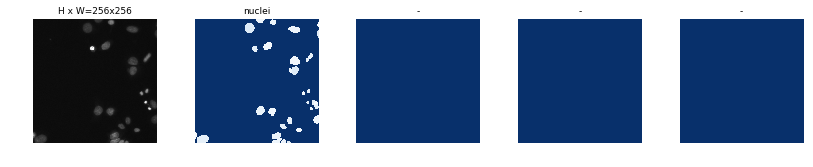

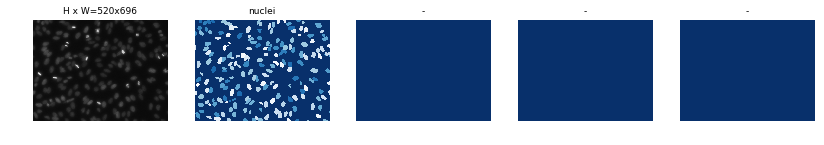

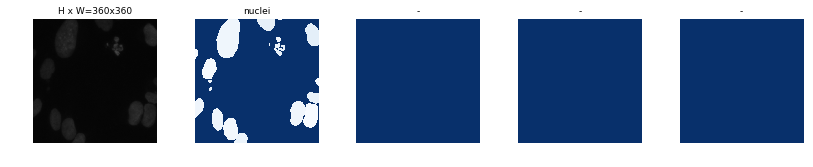

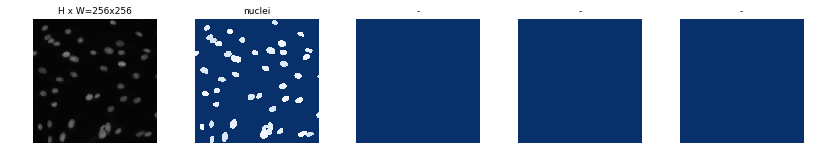

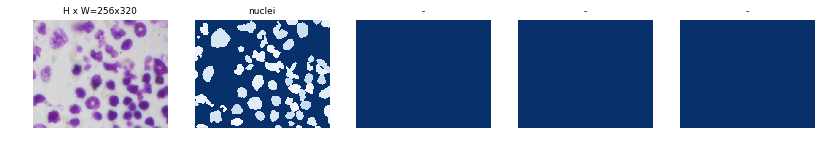

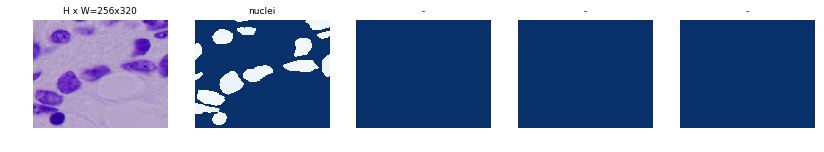

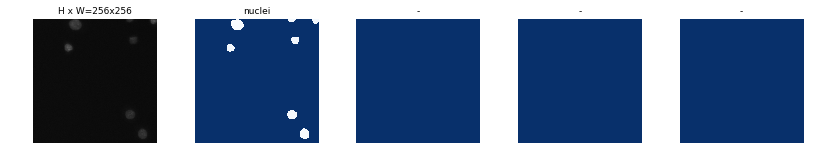

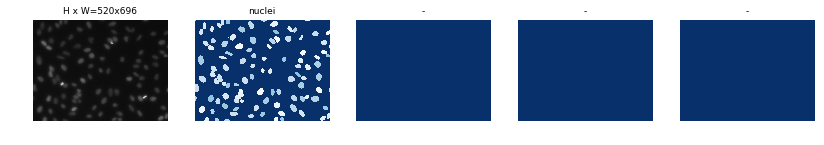

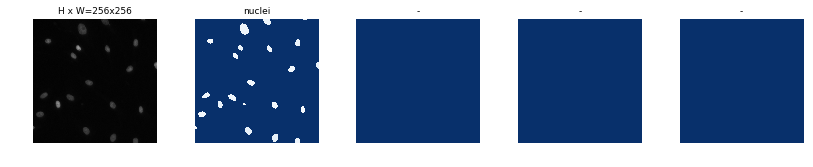

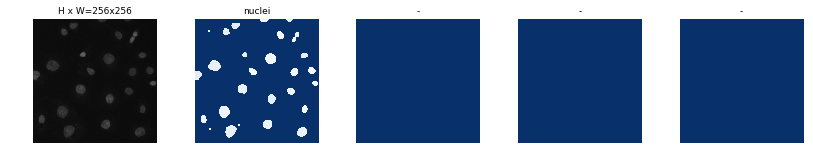

In [7]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 10)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [12]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [13]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

In [14]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=20, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/ubuntu/Mask_RCNN/logs/nuclei_dat20180312T0927/mask_rcnn_nuclei_dat_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
m

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:97: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:2095: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/20
 33/250 [==>...........................] - ETA: 10:32 - loss: 4.2224 - rpn_class_loss: 0.7349 - rpn_bbox_loss: 1.4058 - mrcnn_class_loss: 0.4330 - mrcnn_bbox_loss: 0.7700 - mrcnn_mask_loss: 0.8787

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


 49/250 [====>.........................] - ETA: 9:06 - loss: 3.4943 - rpn_class_loss: 0.5390 - rpn_bbox_loss: 1.2105 - mrcnn_class_loss: 0.3428 - mrcnn_bbox_loss: 0.6541 - mrcnn_mask_loss: 0.7479

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


250/250 [==============================] - 604s 2s/step - loss: 1.8554 - rpn_class_loss: 0.1649 - rpn_bbox_loss: 0.7938 - mrcnn_class_loss: 0.1743 - mrcnn_bbox_loss: 0.3441 - mrcnn_mask_loss: 0.3783 - val_loss: 1.2799 - val_rpn_class_loss: 0.0979 - val_rpn_bbox_loss: 0.5786 - val_mrcnn_class_loss: 0.1889 - val_mrcnn_bbox_loss: 0.1902 - val_mrcnn_mask_loss: 0.2243
Epoch 2/20
250/250 [==============================] - 576s 2s/step - loss: 1.2315 - rpn_class_loss: 0.0525 - rpn_bbox_loss: 0.5756 - mrcnn_class_loss: 0.1503 - mrcnn_bbox_loss: 0.2089 - mrcnn_mask_loss: 0.2443 - val_loss: 1.2263 - val_rpn_class_loss: 0.0785 - val_rpn_bbox_loss: 0.5357 - val_mrcnn_class_loss: 0.2077 - val_mrcnn_bbox_loss: 0.1768 - val_mrcnn_mask_loss: 0.2276
Epoch 3/20
250/250 [==============================] - 577s 2s/step - loss: 1.1065 - rpn_class_loss: 0.0389 - rpn_bbox_loss: 0.4857 - mrcnn_class_loss: 0.1625 - mrcnn_bbox_loss: 0.1883 - mrcnn_mask_loss: 0.2311 - val_loss: 1.1914 - val_rpn_class_loss: 0.0618

# Detection

In [104]:
def metric(true_masks, pred_masks,verbose=0):
    
    (height , width , _)=pred_masks.shape
    # Make a ground truth prediction image (pixel value is index of object pred)
    predictions = np.zeros((height, width), np.uint16)
    for index in range(pred_masks.shape[2]): #donne un label different a chaque masque
        predictions[pred_masks[:,:,index] > 0] = index + 1
    # Make a ground truth label image (pixel value is index of object label)
    labels = np.zeros((height, width), np.uint16)
    for index in range(true_masks.shape[2]): #donne un label different a chaque masque
        labels[true_masks[:,:,index] > 0] = index + 1


    # Compute number of objects
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(predictions))
    if verbose > 0:
        print("Number of true objects:", true_objects-1)
        print("Number of predicted objects:", pred_objects-1)

    # Compute intersection between all objects
    intersection = np.histogram2d(labels.flatten(), predictions.flatten(), bins=(true_objects, pred_objects))[0]
    #matrice de taille (true_objects x pred_objects)
    #chaque case de la matrice correspond au nombre de pixels contenu dans chaque intersection

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]#vecteur qui associe a chaque objet le nombre de pixels qu'il contient
    area_pred = np.histogram(predictions, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]#on retire le fond
    union = union[1:,1:]
    union[union == 0] = 1e-9 #simple precaution

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects, une ligne correspond a un vrai masque, on compte le nombre de vrais masques qui ont une intersection plus grande que iou avec nos propositions
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects, une colonne corespond a un masque predit, on compte le nombre de fois ou l'intersection avec un vrai masque ne depasse pas iou
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects, on compte le nombre de fois ou l'intersection avec une prediction ne depasse pas iou
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn


    # Loop over IoU thresholds
    prec = []
    if verbose > 0 : 
        print("Thresh\tTP\tFP\tFN\tPrec.")#je l'ai garde du code original mais on peut le retirer
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        p = tp*1. / (tp + fp + fn) # il faut certainement changer tp*1. par tp pour qu'il tourne avec python 3
        
        if verbose > 0 : 
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    if verbose > 0 :
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))

    return np.mean(prec)

In [98]:
class InferenceConfig(NucleiConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    # Max number of final detections
    DETECTION_MAX_INSTANCES = 300

    # Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped
    DETECTION_MIN_CONFIDENCE = 0.8
    # ROIs kept after non-maximum supression (training and inference)
    POST_NMS_ROIS_TRAINING = 2000
    POST_NMS_ROIS_INFERENCE = 2000

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/pierre/ownCloud/Thèse/Kaggle-Data-Science-Bowl/pierre/Mask_RCNN/logs/nuclei_dat20180312T0927/mask_rcnn_nuclei_dat_0020.h5


image                    shape: (256, 320, 3)         min:    1.00000  max:  217.00000
class_id                 shape: (7,)                  min:    1.00000  max:    1.00000
bbox                     shape: (7, 4)                min:    0.00000  max:  259.00000
mask                     shape: (256, 320, 7)         min:    0.00000  max:  255.00000


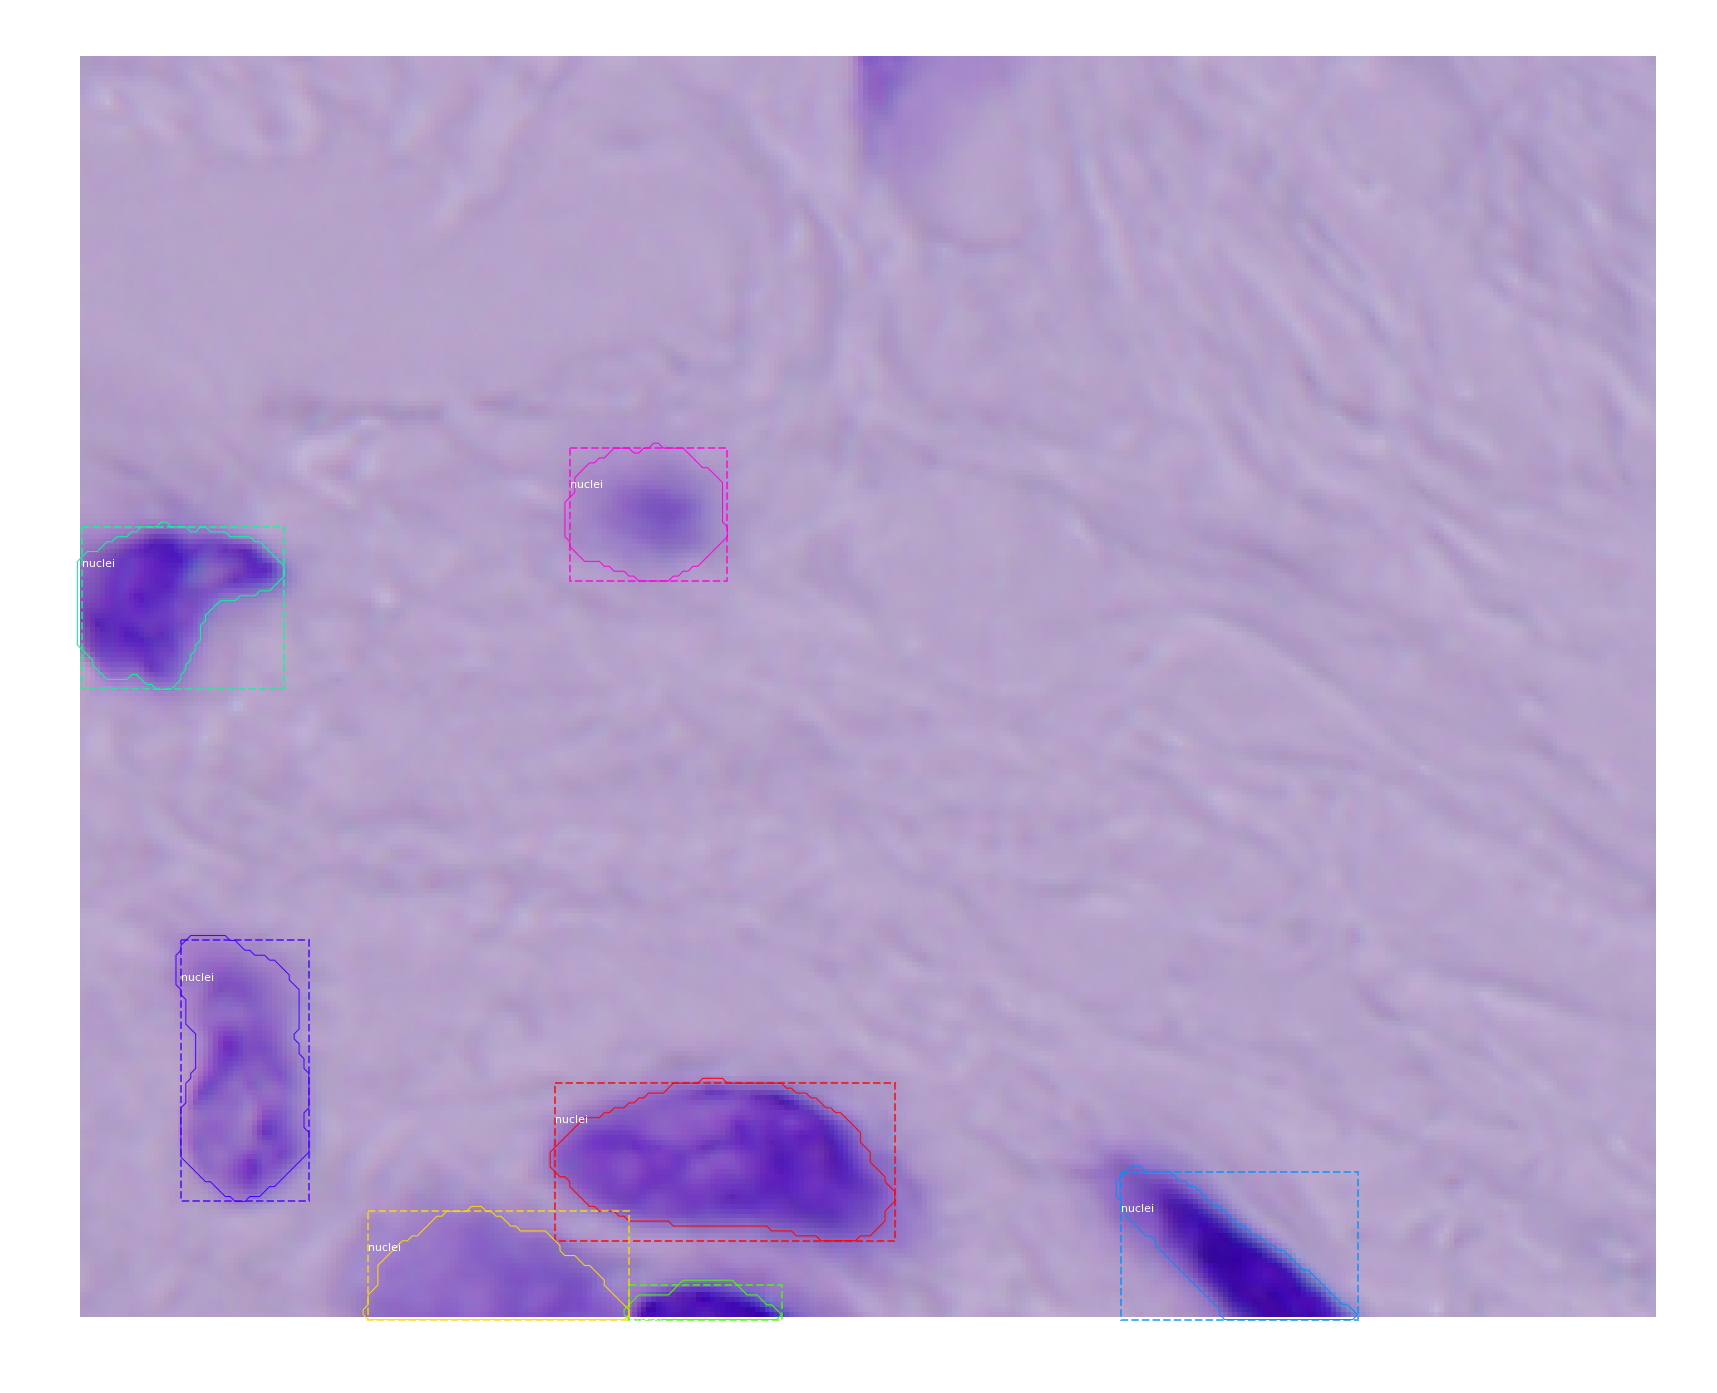

In [99]:
# Test on an image
image_id = dataset_val.image_ids[32]

image = dataset_val.load_image(image_id)
mask, class_ids = dataset_val.load_mask(image_id)
shape = image.shape

# Bounding boxes. 
bbox = utils.extract_bboxes(mask)

log("image", image)
log("class_id", class_ids)
log("bbox", bbox)
log("mask", mask)

visualize.display_instances(image, bbox, mask, class_ids, 
                            dataset_train.class_names, figsize=(30, 30))

In [94]:
results = model.detect([image], verbose=1)

r = results[0]
print(r["masks"].shape)

Processing 1 images
image                    shape: (256, 320, 3)         min:    1.00000  max:  217.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  113.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  672.00000
(256, 320, 7)


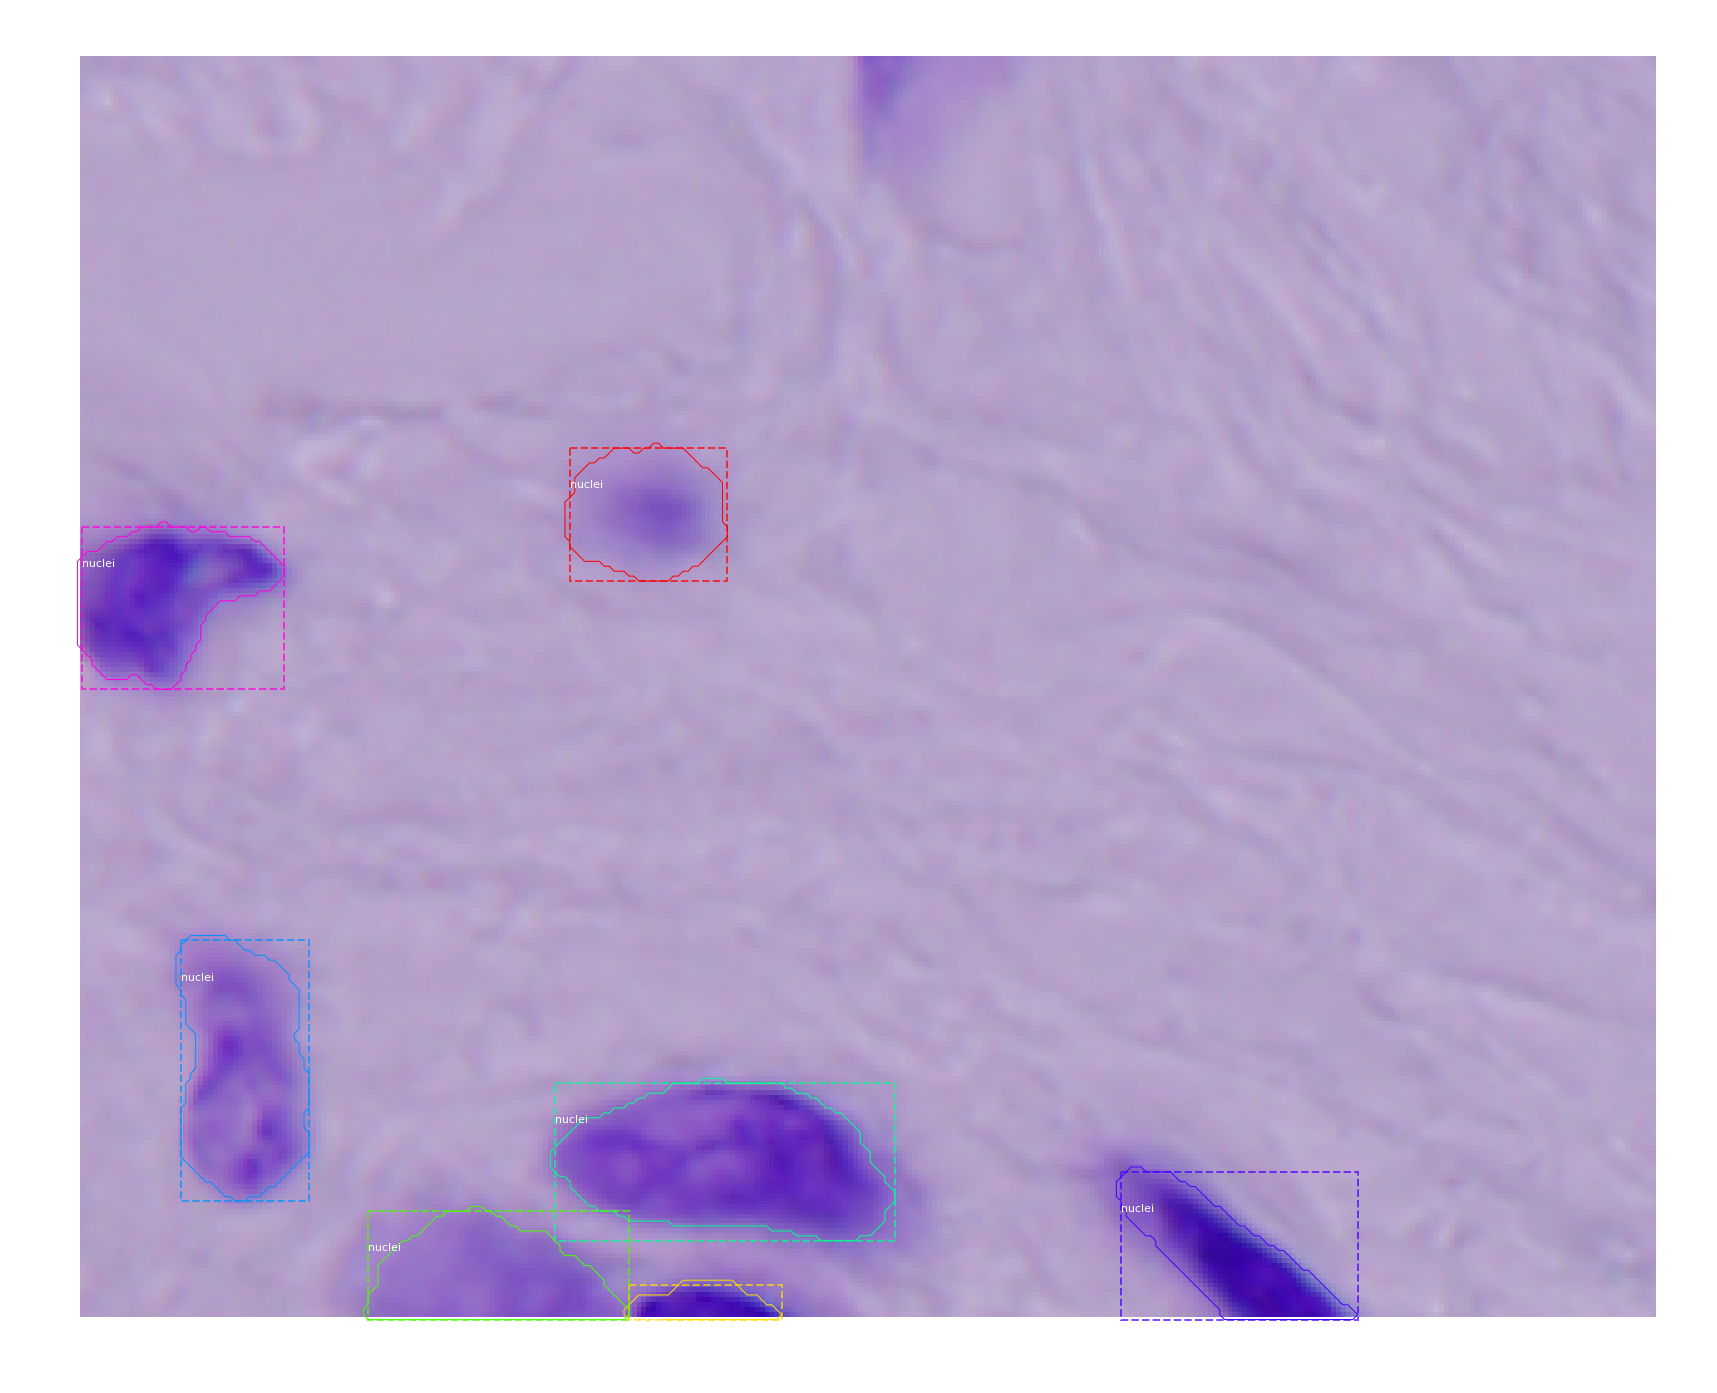

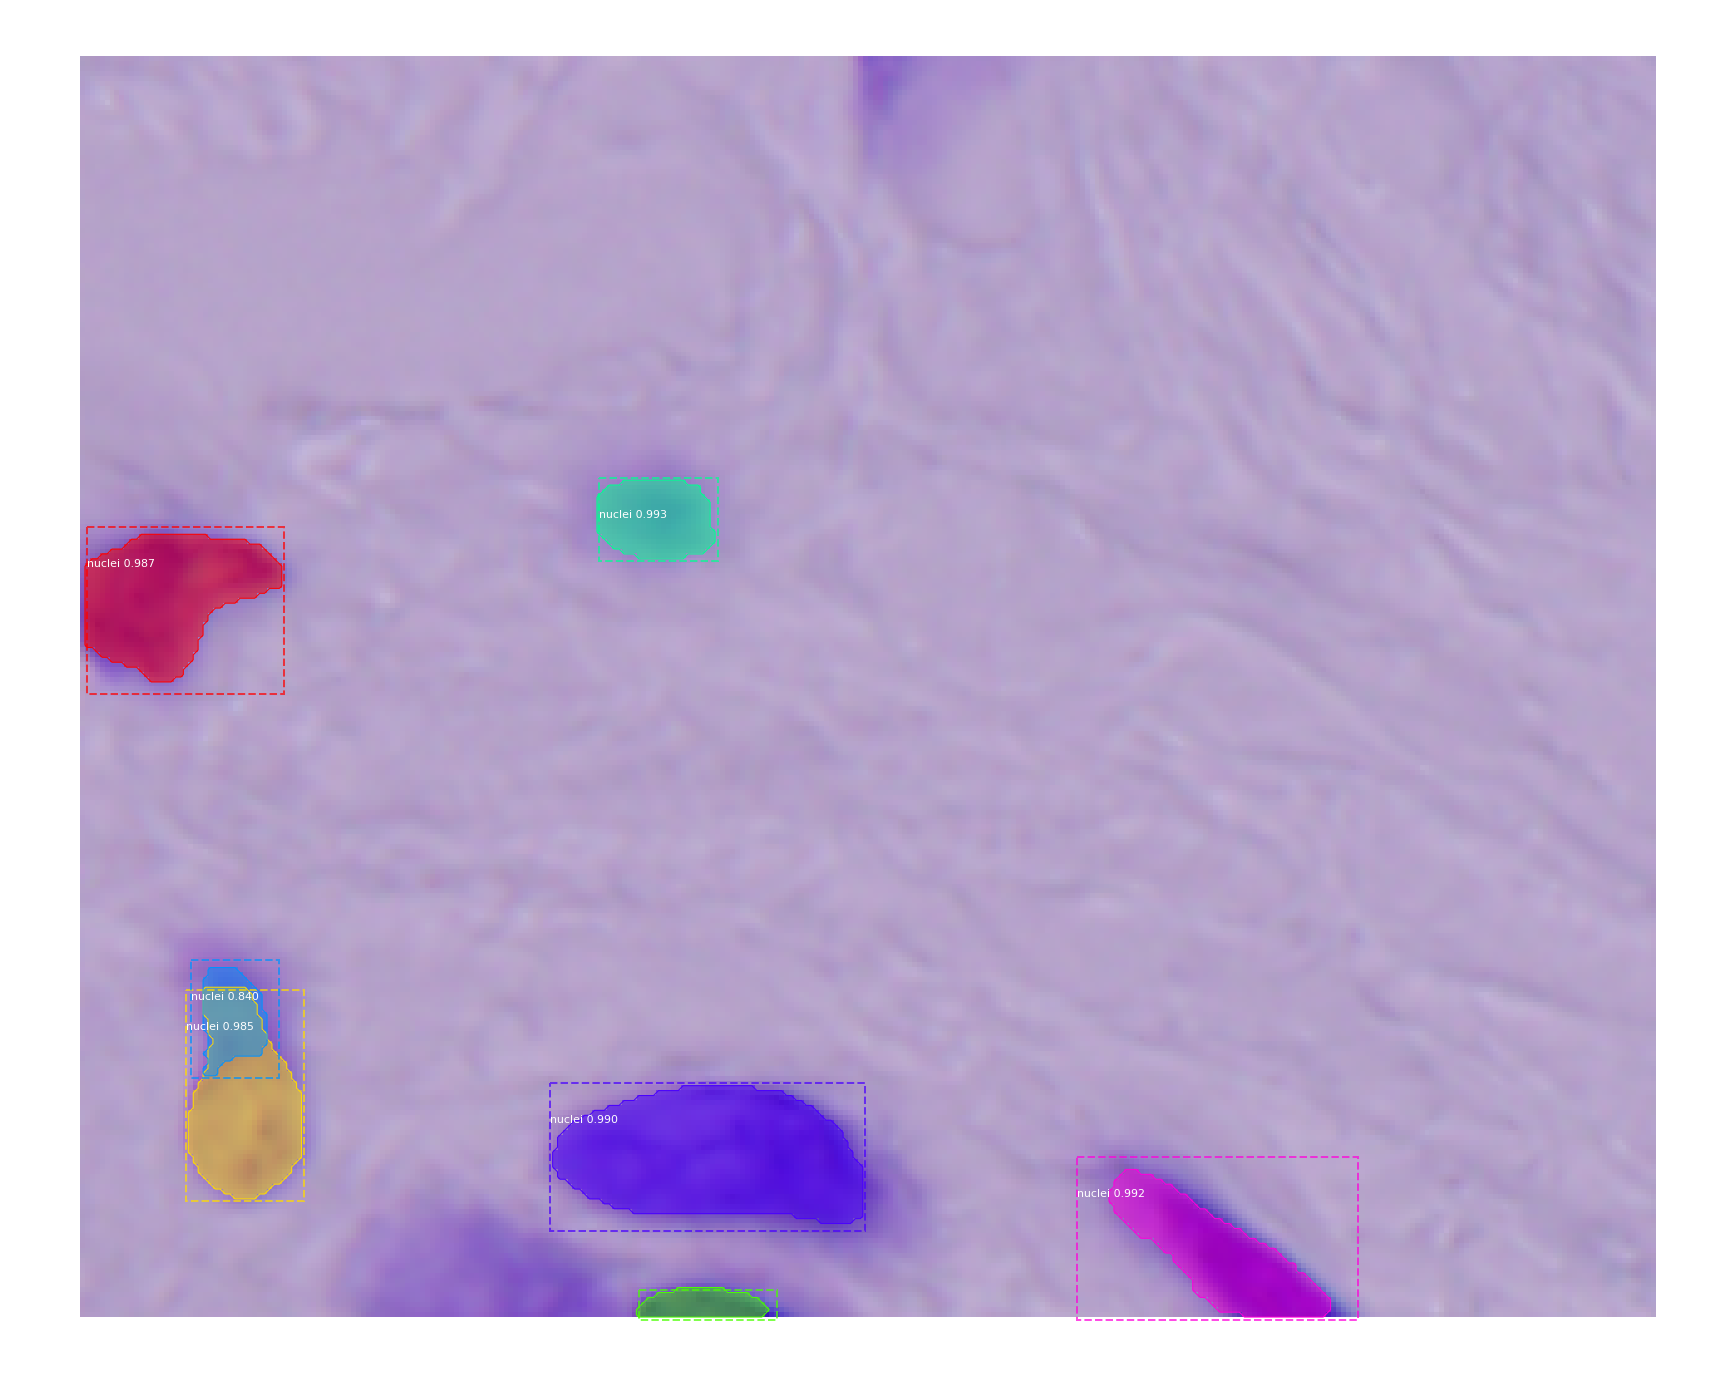

In [95]:
visualize.display_instances(image, bbox, mask, class_ids, 
                            dataset_train.class_names, figsize=(30, 30))
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], figsize=(30, 30))

In [105]:
metric(mask,r["masks"],verbose=1)

Number of true objects: 7
Number of predicted objects: 7
Thresh	TP	FP	FN	Prec.
0.500	4	3	3	0.400
0.550	4	3	3	0.400
0.600	4	3	3	0.400
0.650	4	3	3	0.400
0.700	4	3	3	0.400
0.750	4	3	3	0.400
0.800	4	3	3	0.400
0.850	1	6	6	0.077
0.900	0	7	7	0.000
0.950	0	7	7	0.000
AP	-	-	-	0.288


0.28769230769230775

In [51]:
all_metric=[]
for image_id in dataset_val.image_ids[range(20,40)]:

    image = dataset_val.load_image(image_id)
    mask, class_ids = dataset_val.load_mask(image_id)
    shape = image.shape
    results = model.detect([image], verbose=0)
    r = results[0]
    print( "image id: ", image_id)
    mtr=metric(mask,r["masks"],verbose=1)
    all_metric+=[mtr]

image id:  20
Number of true objects: 38
Number of predicted objects: 37
Thresh	TP	FP	FN	Prec.
0.500	36	0	1	0.973
0.550	36	0	1	0.973
0.600	36	0	1	0.973
0.650	36	0	1	0.973
0.700	36	0	1	0.973
0.750	36	0	1	0.973
0.800	35	1	2	0.921
0.850	34	2	3	0.872
0.900	25	11	12	0.521
0.950	4	32	33	0.058
AP	-	-	-	0.821
image id:  21
Number of true objects: 56
Number of predicted objects: 40
Thresh	TP	FP	FN	Prec.
0.500	37	2	18	0.649
0.550	37	2	18	0.649
0.600	33	6	22	0.541
0.650	32	7	23	0.516
0.700	31	8	24	0.492
0.750	30	9	25	0.469
0.800	28	11	27	0.424
0.850	22	17	33	0.306
0.900	10	29	45	0.119
0.950	1	38	54	0.011
AP	-	-	-	0.418
image id:  22
Number of true objects: 11
Number of predicted objects: 11
Thresh	TP	FP	FN	Prec.
0.500	10	0	0	1.000
0.550	10	0	0	1.000
0.600	10	0	0	1.000
0.650	10	0	0	1.000
0.700	9	1	1	0.818
0.750	9	1	1	0.818
0.800	9	1	1	0.818
0.850	9	1	1	0.818
0.900	7	3	3	0.538
0.950	2	8	8	0.111
AP	-	-	-	0.792
image id:  23
Number of true objects: 197
Number of predicted objects: 27
Thresh	TP	FP	FN	

In [52]:
np.array(all_metric).mean()

0.46288586293793366

In [55]:
dataset_val.image_info[11]['path']

'/home/pierre/ownCloud/Thèse/Kaggle-Data-Science-Bowl/input/stage1_train/5953af5080d981b554529971903d8bee9871457a4361b51f04ba04f43793dd8f/images/5953af5080d981b554529971903d8bee9871457a4361b51f04ba04f43793dd8f.png'

In [33]:
def metric(true_masks, pred_masks,verbose=0):
    
    (height , width , _)=pred_masks.shape
    # Make a ground truth prediction image (pixel value is index of object pred)
    predictions = np.zeros((height, width), np.uint16)
    for index in range(pred_masks.shape[2]): #donne un label different a chaque masque
        predictions[pred_masks[:,:,index] > 0] = index + 1
    # Make a ground truth label image (pixel value is index of object label)
    labels = np.zeros((height, width), np.uint16)
    for index in range(true_masks.shape[2]): #donne un label different a chaque masque
        labels[true_masks[:,:,index] > 0] = index + 1


    # Compute number of objects
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(predictions))



    # Compute intersection between all objects
    intersection = np.histogram2d(labels.flatten(), predictions.flatten(), bins=(true_objects, pred_objects))[0]
    #matrice de taille (true_objects x pred_objects)
    #chaque case de la matrice correspond au nombre de pixels contenu dans chaque intersection

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]#vecteur qui associe a chaque objet le nombre de pixels qu'il contient
    area_pred = np.histogram(predictions, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]#on retire le fond
    union = union[1:,1:]
    union[union == 0] = 1e-9 #simple precaution

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects, une ligne correspond a un vrai masque, on compte le nombre de vrais masques qui ont une intersection plus grande que iou avec nos propositions
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects, une colonne corespond a un masque predit, on compte le nombre de fois ou l'intersection avec un vrai masque ne depasse pas iou
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects, on compte le nombre de fois ou l'intersection avec une prediction ne depasse pas iou
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn


    # Loop over IoU thresholds
    prec = []
    if verbose >1 : 
        print("Thresh\tTP\tFP\tFN\tPrec.")#je l'ai garde du code original mais on peut le retirer
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        p = tp*1. / (tp + fp + fn) # il faut certainement changer tp*1. par tp pour qu'il tourne avec python 3
        
        if verbose > 0 : 
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    if verbose > 0 :
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))

    return np.mean(prec)

# Prediction and sub

In [86]:
path_to_test=os.path.join(path_to_input,"stage1_test")
ImageId_test = next(os.walk(path_to_test))[1]

In [87]:
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def clear_overlap(masks,threshold=0.55):
    res=np.zeros((masks.shape[0],masks.shape[1]),np.int32)
    for k in range(masks.shape[2]):
        l=k+1
        res+=l*masks[:,:,k]
        ind = (res>l)
        if ind.sum()/masks[:,:,k].sum() > threshold:
            res[ind]=l
        else:
            res[ind]+=-l
    return res

def get_rle(masks, threshold=0.5):
    res=clear_overlap(masks,threshold)
    rle=[]
    for k in np.unique(res):
        if k>0:
            rle+=[rle_encoding(res==k)]
    return rle   

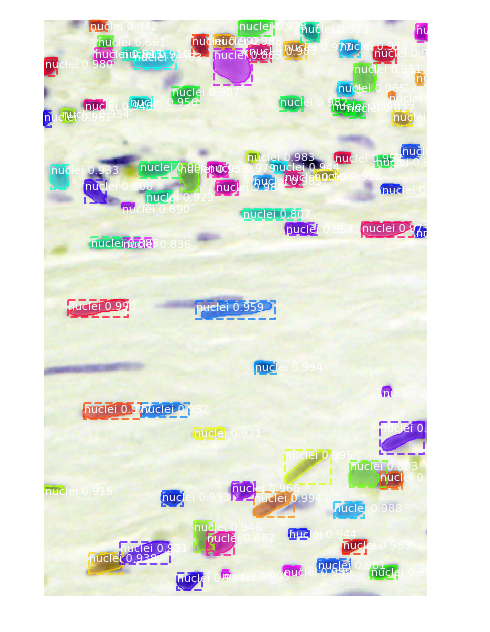

In [88]:
id_=ImageId_test[4]
image = skimage.io.imread(os.path.join(path_to_test,id_,"images",id_+".png"))[:,:,:3]
results = model.detect([image], verbose=0)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], figsize=(11, 11))

In [89]:
new_test_ids = []
rles = []
for n, id_ in enumerate(ImageId_test):
    image = skimage.io.imread(os.path.join(path_to_test,id_,"images",id_+".png"))[:,:,:3]
    
    print(n)
    # Run detection
    results = model.detect([image], verbose=0)

    # Visualize results
    r = results[0]
    
    rle = get_rle(r["masks"])
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64


In [90]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('2018-12-03_pierre_maskrcnn_thsld_0.8.csv', index=False)
sub.head(10)

,ImageId,EncodedPixels
0,0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...,53720 14 54237 18 54754 22 55272 25 55790 27 5...
1,0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...,745 27 1263 29 1782 29 2301 29 2820 29 3339 29...
2,0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...,127 22 645 26 1165 26 1684 25 2203 25 2723 24 ...
3,0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...,326 16 844 19 1362 22 1880 24 2398 25 2916 27 ...
4,0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...,71441 8 71957 14 72475 17 72993 19 73510 22 74...
5,0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...,116257 1 116776 2 117295 2 117814 3 118333 4 1...
6,0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...,52395 5 52914 6 53432 8 53951 8 54470 8 54989 ...
7,0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...,62891 5 63408 9 63926 11 64443 14 64961 16 654...
8,0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...,79178 5 79695 10 80213 13 80731 16 81249 19 81...
9,0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...,40827 5 41343 13 41860 19 42378 22 42896 24 43...
